In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from lr_utils import load_dataset

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [3]:
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]

print("Number of training examples: m_train = " + str(m_train))
print("Number of testing examples: m_test = " + str(m_test))
print("Height/Width of each image: num_px = " + str(num_px))
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_set_x shape: " + str(train_set_x_orig.shape))
print("train_set_y shape: " + str(train_set_y.shape))
print("test_set_x shape: " + str(test_set_x_orig.shape))
print("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [4]:
# Reshape the training and test examples
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

# Check that the first 10 pixels of the second image are in the correct place
assert np.alltrue(
    train_set_x_flatten[0:10, 1] == [196, 192, 190, 193, 186, 182, 188, 179, 174, 213]
), "Wrong solution. Use (X.shape[0], -1).T."
assert np.alltrue(
    test_set_x_flatten[0:10, 1] == [115, 110, 111, 137, 129, 129, 155, 146, 145, 159]
), "Wrong solution. Use (X.shape[0], -1).T."

print("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print("train_set_y shape: " + str(train_set_y.shape))
print("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


In [5]:
train_set_x = train_set_x_flatten / 255.0
test_set_x = test_set_x_flatten / 255.0

In [6]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    s = 1 / (1 + np.exp(-z))

    return s

In [7]:
print("sigmoid([0, 2]) = " + str(sigmoid(np.array([0, 2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


In [8]:
x = np.array([0.5, 0, 2.0])
output = sigmoid(x)
print(output)

[0.62245933 0.5        0.88079708]


In [9]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias) of type float
    """
    
    w = np.zeros((dim, 1))
    b = 0.0

    return w, b

In [10]:
dim = 2
w, b = initialize_with_zeros(dim)

assert type(b) == float
print("w = " + str(w))
print("b = " + str(b))

w = [[0.]
 [0.]]
b = 0.0


In [11]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    grads -- dictionary containing the gradients of the weights and bias
            (dw -- gradient of the loss with respect to w, thus same shape as w)
            (db -- gradient of the loss with respect to b, thus same shape as b)
    cost -- negative log-likelihood cost for logistic regression

    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """

    m = X.shape[1]

    # FORWARD PROPAGATION (FROM X TO COST)
    # compute activation
    A = sigmoid(np.dot(w.T, X) + b)

    # compute cost by using np.dot to perform multiplication.
    # And don't use loops for the sum.
    cost = np.sum(-1 * (Y * np.log(A) + (1 - Y) * np.log(1 - A))) / m

    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = np.dot(X, (A - Y).T) / m
    db = np.sum(A - Y) / m

    cost = np.squeeze(np.array(cost))

    grads = {"dw": dw, "db": db}

    return grads, cost

In [12]:
w = np.array([[1.0], [2]])
b = 1.5
X = np.array([[1.0, -2.0, -1.0], [3.0, 0.5, -3.2]])
Y = np.array([[1, 1, 0]])
grads, cost = propagate(w, b, X, Y)

assert type(grads["dw"]) == np.ndarray
assert grads["dw"].shape == (2, 1)
assert type(grads["db"]) == np.float64


print("dw = " + str(grads["dw"]))
print("db = " + str(grads["db"]))
print("cost = " + str(cost))

dw = [[ 0.25071532]
 [-0.06604096]]
db = -0.12500404500439652
cost = 0.15900537707692405


In [13]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """

    w = copy.deepcopy(w)
    b = copy.deepcopy(b)

    costs = []

    for i in range(num_iterations):
        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule
        w = w - learning_rate * dw
        b = b - learning_rate * db

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

            # Print the cost every 100 training iterations
            if print_cost:
                print("Cost after iteration %i: %f" % (i, cost))

    params = {"w": w, "b": b}

    grads = {"dw": dw, "db": db}

    return params, grads, costs

In [14]:
params, grads, costs = optimize(
    w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False
)

print("w = " + str(params["w"]))
print("b = " + str(params["b"]))
print("dw = " + str(grads["dw"]))
print("db = " + str(grads["db"]))
print("Costs = " + str(costs))

w = [[0.80956046]
 [2.0508202 ]]
b = 1.5948713189708588
dw = [[ 0.17860505]
 [-0.04840656]]
db = -0.08888460336847771
Costs = [array(0.15900538)]


In [15]:
def predict(w, b, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    """

    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)

    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X) + b)

    # Convert probabilities A[0,i] to actual predictions p[0,i]
    Y_prediction = A > 0.5

    return Y_prediction

In [16]:
w = np.array([[0.1124579], [0.23106775]])
b = -0.3
X = np.array([[1.0, -1.1, -3.2], [1.2, 2.0, 0.1]])
print("predictions = " + str(predict(w, b, X)))

predictions = [[ True  True False]]


In [17]:
def model(
    X_train,
    Y_train,
    X_test,
    Y_test,
    num_iterations=2000,
    learning_rate=0.5,
    print_cost=False,
):
    """
    Builds the logistic regression model by calling the function you've implemented previously

    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """
    # initialize parameters with zeros
    # and use the "shape" function to get the first dimension of X_train
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    params, grads, costs = optimize(
        w, b, X_train, Y_train, num_iterations, learning_rate, print_cost
    )

    # Retrieve parameters w and b from dictionary "params"
    w = params["w"]
    b = params["b"]

    print(w)

    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)


    # Print train/test Errors
    if print_cost:
        print(
            "train accuracy: {} %".format(
                100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100
            )
        )
        print(
            "test accuracy: {} %".format(
                100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100
            )
        )

    d = {
        "costs": costs,
        "Y_prediction_test": Y_prediction_test,
        "Y_prediction_train": Y_prediction_train,
        "w": w,
        "b": b,
        "learning_rate": learning_rate,
        "num_iterations": num_iterations,
    }

    return d

In [18]:
logistic_regression_model = model(
    train_set_x,
    train_set_y,
    test_set_x,
    test_set_y,
    num_iterations=2000,
    learning_rate=0.005,
    print_cost=True,
)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
[[ 0.00961402]
 [-0.0264683 ]
 [-0.01226513]
 ...
 [-0.01144453]
 [-0.02944783]
 [ 0.02378106]]
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


y = 1, you predicted that it is a "non-cat" picture.


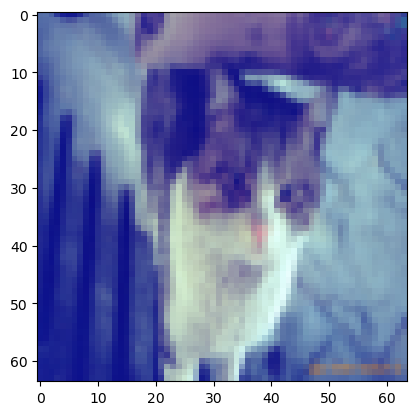

In [19]:
# Example of a picture that was wrongly classified.
index = 41

plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print(
    "y = "
    + str(test_set_y[0, index])
    + ', you predicted that it is a "'
    + classes[int(logistic_regression_model["Y_prediction_test"][0, index])].decode(
        "utf-8"
    )
    + '" picture.'
)

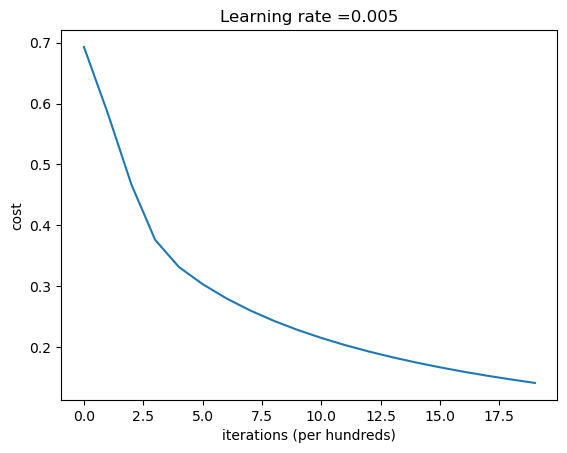

In [20]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model["costs"])
plt.plot(costs)
plt.ylabel("cost")
plt.xlabel("iterations (per hundreds)")
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()

Training a model with learning rate: 0.01
[[ 0.01280149]
 [-0.03466593]
 [-0.01552747]
 ...
 [-0.01481023]
 [-0.03723668]
 [ 0.03117718]]

-------------------------------------------------------

Training a model with learning rate: 0.001
[[ 0.00388218]
 [-0.00802229]
 [-0.00375977]
 ...
 [-0.0042936 ]
 [-0.01110565]
 [ 0.00659217]]

-------------------------------------------------------

Training a model with learning rate: 0.0001
[[ 0.00090564]
 [-0.00099018]
 [-0.00014868]
 ...
 [-0.00051939]
 [-0.00179446]
 [ 0.00090753]]

-------------------------------------------------------



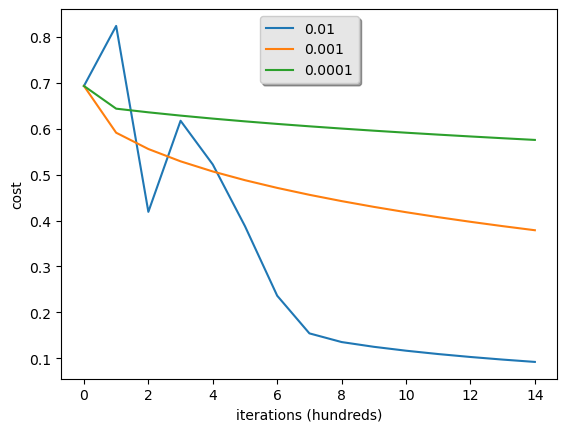

In [21]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(
        train_set_x,
        train_set_y,
        test_set_x,
        test_set_y,
        num_iterations=1500,
        learning_rate=lr,
        print_cost=False,
    )
    print("\n" + "-------------------------------------------------------" + "\n")

for lr in learning_rates:
    plt.plot(
        np.squeeze(models[str(lr)]["costs"]),
        label=str(models[str(lr)]["learning_rate"]),
    )

plt.ylabel("cost")
plt.xlabel("iterations (hundreds)")

legend = plt.legend(loc="upper center", shadow=True)
frame = legend.get_frame()
frame.set_facecolor("0.90")
plt.show()